# Building a vectorDB from a set of YouTube urls

The notebook will show how to easily build Q+A assistants for any YouTube channel.

## Pick a YouTube channel

We can easily get all the channel metadata with `youtubesearchpython`!

We will test this with the Karpathy course on LLMs.

In [ ]:
! pip install youtube-search-python

In [13]:
from youtubesearchpython import *
import pandas as pd

# Enter the YouTube channel of interest to you
channels = ChannelsSearch('AndrejKarpathy')

# Get the "channel_id" for the set of videos you want (see below)
channels.result()

# Videos
channel_id = "UCXUPKJO5MZQN11PqgIvyuvQ" # Get ID from ChannelsSearch
playlist = Playlist(playlist_from_channel_id(channel_id))
stor_metadata=pd.DataFrame()

# Iterate through videos
for v in playlist.videos:
    # Exclude some videos that we don't care about
    if "Stable diffusion" not in v['title']:
        stor_metadata.loc[v['title'],'link']=v['link']
        stor_metadata.loc[v['title'],'title']=v['title']
        stor_metadata.loc[v['title'],'img']=v['thumbnails'][3]['url']

stor_metadata

,link,title,img
"Let's build GPT: from scratch, in code, spelled out.",https://www.youtube.com/watch?v=kCc8FmEb1nY&li...,"Let's build GPT: from scratch, in code, spelle...",https://i.ytimg.com/vi/kCc8FmEb1nY/hqdefault.j...
Building makemore Part 5: Building a WaveNet,https://www.youtube.com/watch?v=t3YJ5hKiMQ0&li...,Building makemore Part 5: Building a WaveNet,https://i.ytimg.com/vi/t3YJ5hKiMQ0/hqdefault.j...
Building makemore Part 4: Becoming a Backprop Ninja,https://www.youtube.com/watch?v=q8SA3rM6ckI&li...,Building makemore Part 4: Becoming a Backprop ...,https://i.ytimg.com/vi/q8SA3rM6ckI/hqdefault.j...
"Building makemore Part 3: Activations & Gradients, BatchNorm",https://www.youtube.com/watch?v=P6sfmUTpUmc&li...,Building makemore Part 3: Activations & Gradie...,https://i.ytimg.com/vi/P6sfmUTpUmc/hqdefault.j...
Building makemore Part 2: MLP,https://www.youtube.com/watch?v=TCH_1BHY58I&li...,Building makemore Part 2: MLP,https://i.ytimg.com/vi/TCH_1BHY58I/hqdefault.j...
The spelled-out intro to language modeling: building makemore,https://www.youtube.com/watch?v=PaCmpygFfXo&li...,The spelled-out intro to language modeling: bu...,https://i.ytimg.com/vi/PaCmpygFfXo/hqdefault.j...
The spelled-out intro to neural networks and backpropagation: building micrograd,https://www.youtube.com/watch?v=VMj-3S1tku0&li...,The spelled-out intro to neural networks and b...,https://i.ytimg.com/vi/VMj-3S1tku0/hqdefault.j...


In [15]:
# Great! Let's hard-code an index, which will be easier to work with later
video_id=[7,6,5,4,3,2,1]
stor_metadata['lecture_no']=video_id

## Audio to text

We can easily get text for all the videos using LangChain.

In [8]:
from langchain.document_loaders.generic import GenericLoader
from langchain.document_loaders.parsers import OpenAIWhisperParser
from langchain.document_loaders.blob_loaders.youtube_audio import YoutubeAudioLoader

We will use `yt_dlp` to download audio for YouTube urls.

We will use `pydub` to split downloaded audio files (such that we adhere to Whisper API's 25MB file size limit).

In [ ]:
! pip install yt_dlp
! pip install pydub

### YouTube url to text

Use `YoutubeAudioLoader` to fetch / download the audio files.

Then, ues `OpenAIWhisperParser()` to transcribe them to text.

In [ ]:
# Karpathy lecture videos
urls=list(stor_metadata.link)

# Directory to save audio files 
save_dir = "~/Downloads/YouTube"

# Transcribe the videos to text
loader = GenericLoader(YoutubeAudioLoader(urls,save_dir),OpenAIWhisperParser())
docs = loader.load()

In [7]:
# Returns a list of Documents, which can be easily viewed or parsed
docs[0].page_content[0:500]

"Hi everyone. Today we are continuing our implementation of Makemore. Now in the last lecture we implemented the multilayer perceptron along the lines of Benji Oettel 2003 for character level language modeling. So we followed this paper, took in a few characters in the past, and used an MLP to predict the next character in a sequence. So what we'd like to do now is we'd like to move on to more complex and larger neural networks, like recurrent neural networks and their variations like the GRU, LS"

### Building a chat app from YouTube video

In [21]:
import os
import math
import pinecone
import pandas as pd
from langchain.chains import RetrievalQA
from langchain.vectorstores import Pinecone
from langchain.chat_models import ChatOpenAI
from langchain.embeddings import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter

`First, set up your Pinecone VectorDB`

* Go to Pinecone console
* Create your index e.g., `karpathy-gpt`
* Ensure the `Dimensions` matches your embedding (e.g., `1536` for `OpenAIEmbeddings`)

`In the UI, we will want metadata to be displayed with each document`

* For example, see the UI below: under the the answer, we have each retrieved document from the vectorDB.
* The document has a title, link, and image. These come from the document metadata!
* So, below we will split texts and also add metadata.

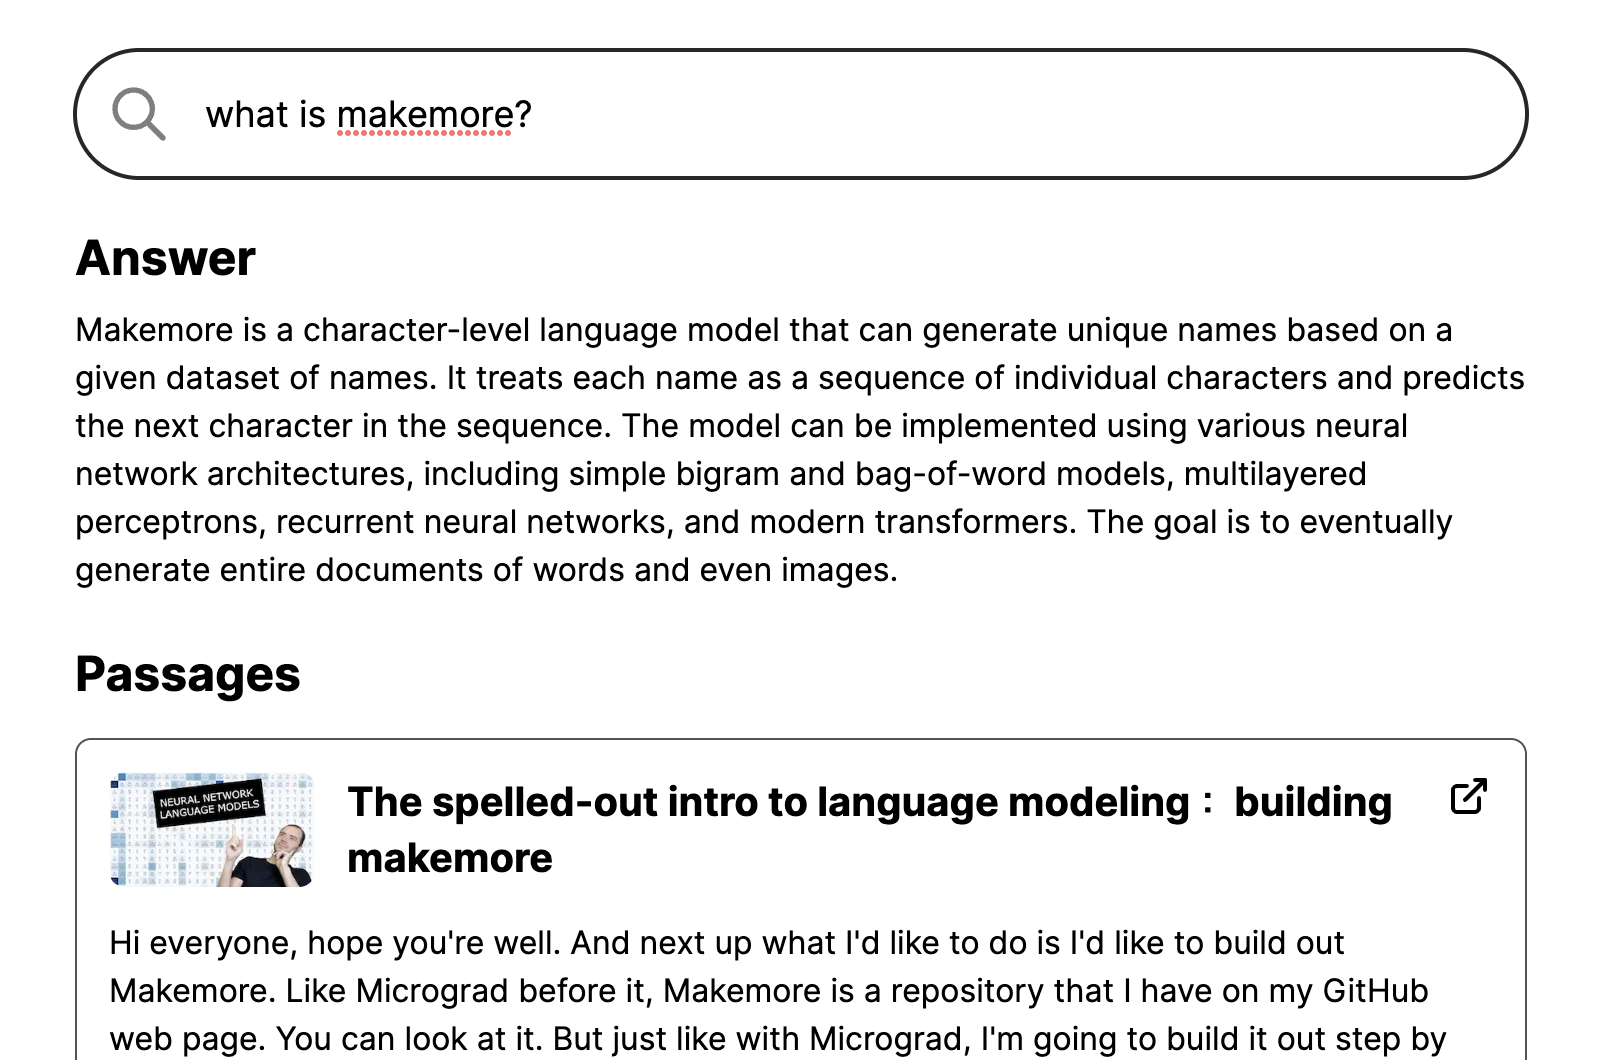

In [9]:
# Consolidate text per episode
concatenated_text_by_source = {}
for doc in docs:
    source = doc.metadata['source']
    page_content = doc.page_content
    if source in concatenated_text_by_source:
        concatenated_text_by_source[source] += ' ' + page_content
    else:
        concatenated_text_by_source[source] = page_content

`Split and add metadata`

In [11]:
# Split each ep and add metadata we'll use in UI
splits=[]
metadatas=[]

# Split parameters
text_splitter = RecursiveCharacterTextSplitter(chunk_size = 1500, chunk_overlap = 150)

# Build splits
for k in concatenated_text_by_source.keys():
    
    # Get downloaded title
    directory, filename = os.path.split(k)
    video_name = filename.split(".m4a")[0]    
    
    # Make splits
    episode_text = concatenated_text_by_source[k]
    episode_splits = text_splitter.split_text(episode_text)
    splits.append(episode_splits)
    
    # With title, we can fetch associated metadata we wrote earlier to stor_metadata
    episode_number = stor_metadata.loc[video_name,"lecture_no"]
    episode_link = stor_metadata.loc[video_name,"link"]  
    
    # Save the video thumbnail for later use the UI
    with open("../nextjs/public/0%s.jpg"%str(episode_number), 'wb') as f:
        response = requests.get(img_url)
        f.write(response.content)
    
    # Save metadata
    episode_metadatas=[{"source":video_name + " " +episode_no,"id":episode_number,"link":episode_link,"title":video_name} for s in episode_splits]
    metadatas.append(episode_metadatas)

In [ ]:
# Join the list of lists 
splits_all = []
for sublist in splits:
    splits_all.extend(sublist)
metadatas_all = []
for sublist in metadatas:
    metadatas_all.extend(sublist)

`Write to vectorDB`

In [6]:
# Pinecone
pinecone.init(
    api_key=os.environ.get('PINECONE_API_KEY'),  
    environment="YOUR_REGION"  
)

# Update
index_name = "karpathy-gpt"
embeddings = OpenAIEmbeddings()
p = Pinecone.from_existing_index(index_name=index_name,embedding=embeddings)

# Add data in chunk to avoid data ingest errors
chunk_size = 100
last_chunk = 0
num_chunks = math.ceil(len(splits_all) / chunk_size)
for i in range(last_chunk,num_chunks):
    
    # Set chunks to add
    start_idx = i * chunk_size
    end_idx = min(start_idx + chunk_size, len(splits_all))
    
    # Extract the current chunks
    current_splits = splits_all[start_idx:end_idx]
    current_metadatas = metadatas_all[start_idx:end_idx]
    
    # Add the current chunk to the vector database
    p.add_texts(texts = current_splits, metadatas=current_metadatas)

`Test VectorDB`    

In [66]:
# Connect to our VectorDB to test it
pinecone.init(
    api_key=os.environ.get('PINECONE_API_KEY'),  
    environment="YOUR_REGION"  
)
index_name = "karpathy-gpt"
embeddings = OpenAIEmbeddings()
p = Pinecone.from_existing_index(index_name=index_name,embedding=embeddings)

# Build a to test QA chain
qa_chain = RetrievalQA.from_chain_type(llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0),
                                       chain_type="stuff",
                                       retriever=p.as_retriever())

query = "What is Makemore?"
qa_chain.run(query)

'Makemore is a character-level language model that can generate more of things that you give it. For example, if you give it a dataset of names, it can generate more unique names that sound name-like. It is built step by step and spelled out on a GitHub repository. The model is implemented using various neural network architectures, from simple bigram and bag-of-word models to modern transformers.'